#### XARRAY BUILDER
This notebook was created, with a lot of help from others in the group, to import some existing files and convert them into a single xarray dataset. 

All the data are arranged on a 7569 x 17002 pixel grid that corresponds to UTM northings and eastings for a watershed in Yosemite's Hetch Hetchy Valley. 
One primary building block of the xarray is a set of 19 distinct observations of snow depth (each based on the difference in elevation between a snow-off DEM and a single lidar observation with snow-on). These were gathered during the years 2017 and 2019. The other building block is a file, on the same UTM grid, that depicts the snow-off topography, vegetation height, and some other variables that we ultimately don't use. That second dataset also contains a mask that separates the square project grid into pixels within the watershed and those outside it.

Ultimately, the goal was to make our own version of this little cartoon:

<img src='dataset-diagram.png'/>   

#### IMPORT LIBRARIES

In [5]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

#### SET UP DASK CLIENT

We spent some time working with Scott and Anthony on data management issues--a significant concern because this is a really big dataset, once assembled. For technical reasons related to the organizaton of our workspace on pangio, we ultimately found the use of the ASK client
to be disfunctional, so this code isn't used. But here it is, for reference.

In [ ]:
# from dask.distributed import Client

# client = Client("tcp://192.168.44.105:33903")
# client

#### SET UP PATHS TO DATA
Here we locate the 19 files that contain the snow depth data, and also the single datafile that contains the topo data 

In [14]:
# Set path to netCDF files *NOTE, only want files ending in *int.nc. Those particular files are saved as integers in units [cm])
path = '/srv/shared/deep_stac/data/snowdepth/netcdf/20*/*int.nc'

# Develop filelist, 'flist', of snow observations in 2015 & 2017
flist = glob.glob(path, recursive=True)
flist = sorted(flist)

# Parse dates, store as pandas datetime type in list
fparse = [d.split('/')[-1] for d in flist] #splits fname on '/' saves last
fparse = [d.split('_')[0] for d in fparse] #splitting fname on '_' and saves first
# dates is a vector of snow depth observation dates
dates = pd.to_datetime(fparse) #pandas datetime variable of all lidar dates

# Set path to topo files
path_to_topo = '/srv/shared/deep_stac/data/topo.nc'

#### OPEN AND CLEAN UP LIDAR-DERIVED SNOW DEPTH FILES
Here we start ds, the xarray that will hold all our data. We start by opening and adding all 19 snowdepth files, concatenating them over a dimension we call time, and chunking them so that each chunk has ~1,000,000 items. 

We do a little cleanup to remove an unneeded variable (transverse_mercator), and also add a datefile-type variable "time" to the xarray. We also rename the default name, Band1, to "snow".

The code throws a warning message but works fine.

In [1]:
#load xarray (*note, gives an error, it's okay!)
ds=xr.open_mfdataset(flist, concat_dim='time', chunks={'x':1000, 'y':1000}) #dataset
# flip along y-axis

## remove unneeded transverse mercator variable
ds = ds.drop('transverse_mercator')
#add 'time' coordinate #note, by default this populates with a dimension called 'time'
ds['time'] = (['time'], dates)
# rename Band1 "snow"
ds.rename({'Band1' : 'snow'}, inplace=True)
ds.close()

NameError: name 'xr' is not defined

#### OPEN AND CLEAN UP TOPOGRAPHIC DATA
Here we start dtopo, which is a temporary file we'll later combine with the main xarray, ds. We are only going to keep three of the variables in the original datafile: the dem, veg-height, and a mask. 

In [10]:
# open the dataset as 'temp'. chunk it.
temp = xr.open_dataset(path_to_topo,chunks={'x':1000, 'y':1000})
temp.close()

# select variables of interest. 'mask' is for area of interest, 0 elsewhere
add_to_lidar = ['dem','veg_height','mask']
# dtopo is the dataset with only the desired variables
dtopo = temp[add_to_lidar]
dtopo.close()

#### COMBINE SNOW AND TOPO DATA IN ONE XARRAY 
Add the topo data (contained in dtopo) to 'ds', then print the attributes of our final xarray.

In [11]:
# add in topo variables
ds['dem'] = (['y','x'],dtopo.dem)
ds['veg'] = (['y','x'],dtopo.veg_height)
ds['mask'] = (['y','x'],dtopo.mask)
# show attributes
print(ds)

<xarray.Dataset>
Dimensions:  (time: 19, x: 17569, y: 17002)
Coordinates:
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * y        (y) float64 4.179e+06 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
  * time     (time) datetime64[ns] 2015-04-03 2015-05-28 ... 2017-01-29
Data variables:
    snow     (time, y, x) float32 dask.array<shape=(19, 17002, 17569), chunksize=(1, 1000, 1000)>
    dem      (y, x) float32 2633.369 2635.3313 2635.3313 ... 3064.8484 3064.3577
    veg      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 17.5 17.5 17.5 17.5 17.5
    mask     (y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.4.1, released 2019/03/15
    history:             Wed Sep 11 15:41:18 2019: GDAL CreateCopy( /srv/shar...


#### SAVE AS NETCDF FILE
This code would save our final file, 'ds', as a netcdf file called 'snotopo.nc'
It seemed to take forever to run, however, so we never successfully completed it.

In [12]:
#dataDIR = '~/srv/shared/deep_stac/snotopo.nc'
# dataDIR = '/home/jovyan/snotopo.nc'
# print(dataDIR)
# ds.to_netcdf(path=dataDIR,mode='w')

#### Experimenting with plotting and filtering

(17002, 17569)


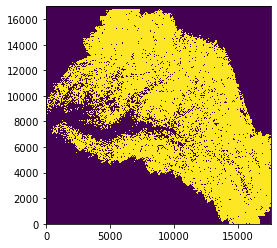

In [12]:
# Find mean snow depth for all time slices in 2015
d = ds.sel(time='2015').snow
mean2015=ds.sel(time='2015').snow.mean(dim='time')
print((mean2015.shape))
# remove snow-free areas
mean2015=mean2015>0
mean2015.shape
plt.imshow(mean2015>0, origin='lower')

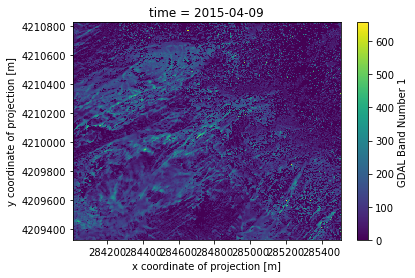

In [13]:
# Plot a slice of the sixth snow depth measurement 
ds.snow.isel(time=5, x = slice(10000,10500), y=slice(10000,10500)).plot()

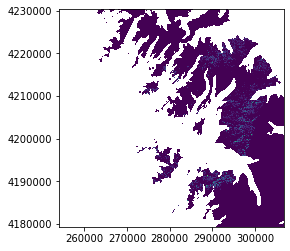

In [14]:
# Plot snowdepth for one time interval only above 2900 m
# this grabs snow depth for all time intervals
snow2900 = ds.snow.where(ds.dem > 2900)

# find images extents
xmin = np.min(ds['x'].values)
xmax = np.max(ds['x'].values)
ymin = np.min(ds['y'].values)
ymax = np.max(ds['y'].values)
# plot only for one time interval
plt.imshow(snow2900[0], extent=[xmin, xmax, ymin, ymax])

In [15]:
# create new dataset for all observations in a given year
ds15 = ds.sel(time='2015')

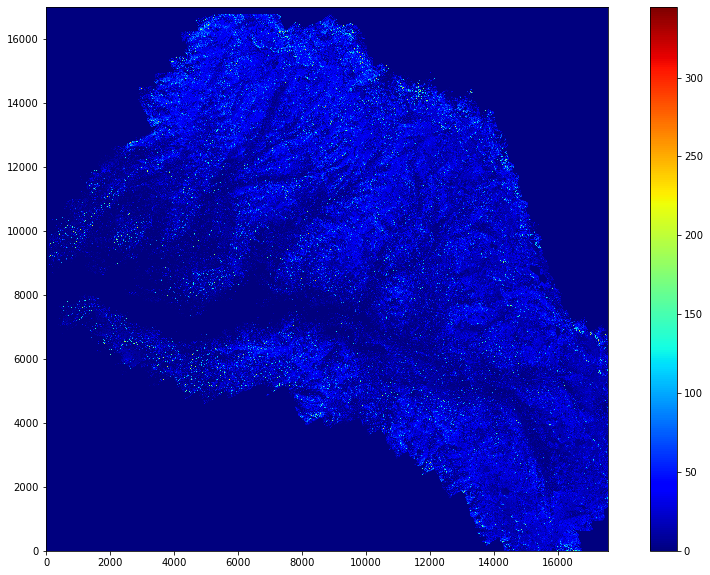

In [16]:
# calculate standard deviation of snow depths in 2015
std = ds.sel(time='2015').snow.std(dim='time')

# mean_sd_15 = ds15.snow.std(dim='flights')
fig = plt.figure(figsize=(15, 10))
plt.imshow(std, origin='lower', cmap='jet')#, vmin=.01, vmax=2.0)
plt.colorbar()
plt.show()
